In [1]:
import numpy as np
import matplotlib
%matplotlib nbagg

from matplotlib import pyplot as plt
from dstpy3 import *
from optictools import *
from time import time
import scipy.io as sio




def pmax(t0): 
	return np.abs(b2)/gamma / t0**2

b2 = -23e-27
gamma = 0.0037
t0 = 1e-12



fr=0.05
tvec=np.linspace(-10e-12,10e-12,2**10)
t0 = fr * 20e-12
p = pmax(t0)
feld = 3.2* np.sqrt(p) / np.cosh( tvec/t0) * np.exp( -1.0j * 2 * np.pi * .01e12 * tvec)
dt = tvec[2]-tvec[1]

dob = DSTObj(feld, tvec, b2, gamma)

zetas = np.linspace(0, 1.1 * dob.zetamax,111)
if False:
    #abalgos:
    plt.figure()
    for k in dob.calc_ab_methodsdict.keys():
        t1 = time()
        a,b = dob.calc_ab(1.0j * zetas, method = k)
        t2 = time()

        ts = k+" %.2f"%(t2-t1)
        #plt.title(dob.calc_ab_methodnamesdict[k]+" %.2f"%(t2-t1))
        plt.plot(zetas, np.log(1./np.abs(a)), label=ts)
    plt.legend(loc=0)

    plt.figure()
    for k in dob.calc_abdiff_methodsdict.keys():
        t1 = time()
        a,b,ad,bd = dob.calc_abdiff(1.0j * zetas, method = k)
        t2 = time()

        ts = k+" %.2f"%(t2-t1)
        #plt.title(dob.calc_ab_methodnamesdict[k]+" %.2f"%(t2-t1))
        plt.plot(zetas, np.log(1./np.abs(a)), label=ts)
    plt.legend(loc=0)


#
# check whether it can handle scalar zeta input
#

if False:
    print(" ---- calc_ab Methods ----")
    for k in dob.calc_ab_methodsdict.keys():

        a,b = dob.calc_ab(1.0j * zetas[10], method = k)
        a2,b2 = dob.calc_ab(1.0j * zetas[10:12], method = k)
        print("--")
        print(a)
        print(a2)       
    print(" ---- calc_abdiff Methods ----")
    for k in dob.calc_abdiff_methodsdict.keys():
        print(k, dob.calc_abdiff_methodnamesdict[k])
        a,b, ad, bd = dob.calc_abdiff(1.0j * zetas[10], method = k)
        a2,b2, ad2, bd2 = dob.calc_abdiff(1.0j * zetas[10:12], method = k)
        print("--")
        print(a)
        print(a2)       
    

# check grid dependency (finished)

<IPython.core.display.Javascript object>


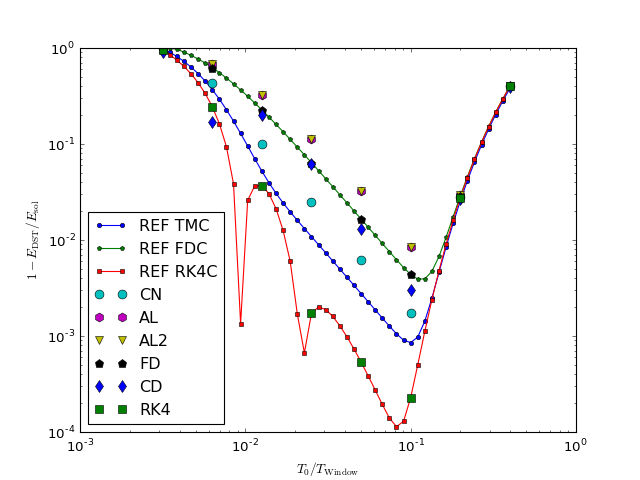

<IPython.core.display.Javascript object>


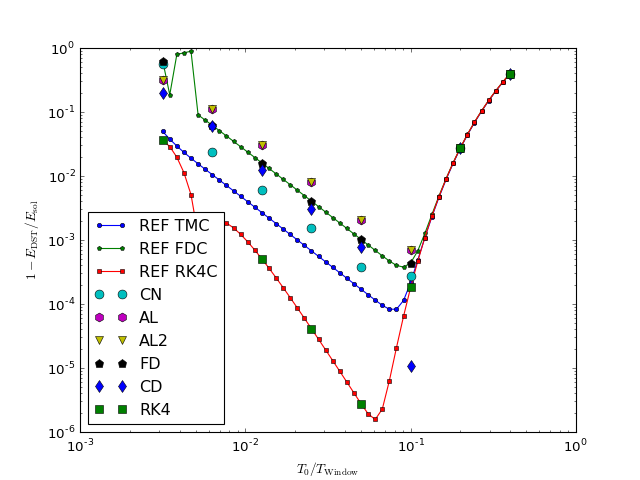

<IPython.core.display.Javascript object>


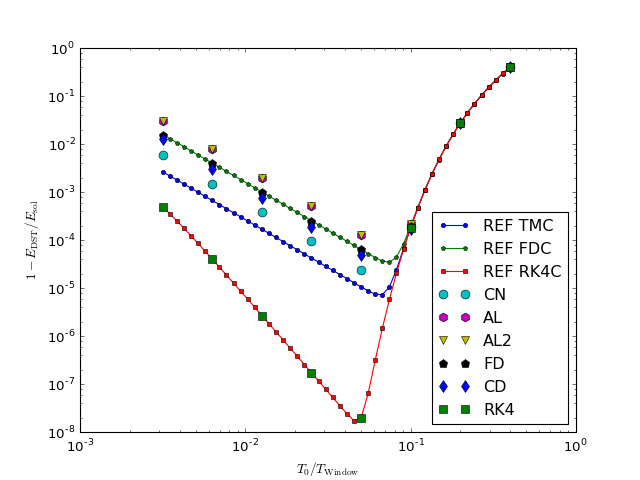

<IPython.core.display.Javascript object>


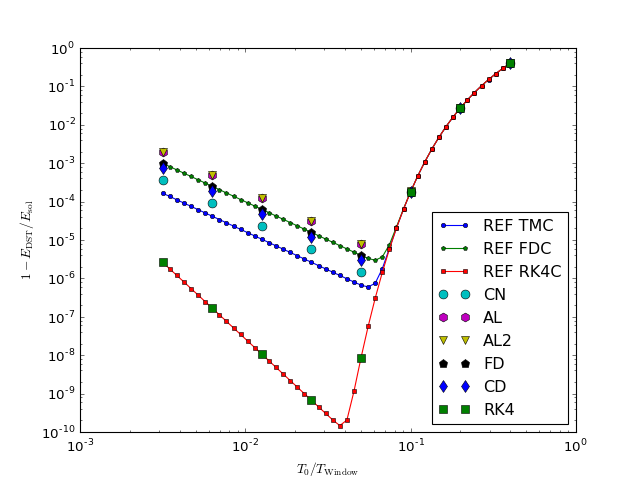

<IPython.core.display.Javascript object>


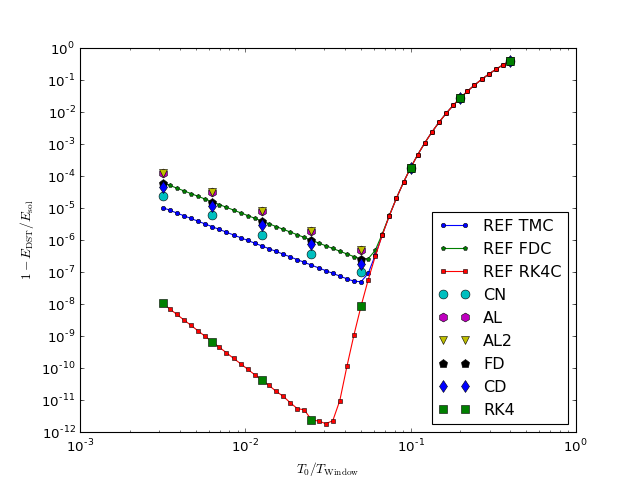

<IPython.core.display.Javascript object>


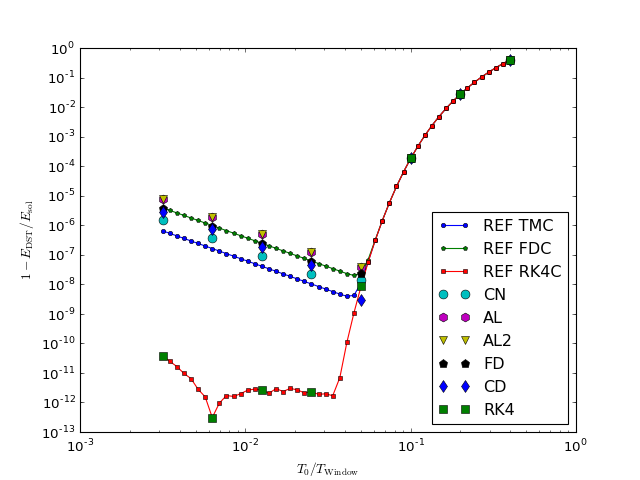

In [3]:


def pfloop3(do, inizetas, Meth, verbose=False, iterations=10):
	zetas = inizetas
	for i in range(iterations):
		aa,bb = do.calc_ab(1.0j*zetas, method=Meth)
		la = np.log(1./np.abs(aa)) 
		pl = pyfindpeaks(5,la,0)
		zpeak = zetas[pl[0]]
		zetas = np.linspace( (1-0.05**i)* zpeak, (1+0.05**i)*zpeak,len(inizetas))
		if verbose:
			if i==0:
				plt.figure()
				plt.plot(zetas,la)
				plt.plot(zetas[pl],la[pl],'o' )
			print("%d - %e	  la = %e"%(i, zpeak*4.0/do.energyfactor, la[pl[0]]))
	return zpeak
#
# ATTENTION: this literally can take HOURS
#
if False:
    from optictools import pyfindpeaks
    for NN in [6,8,10,12,14,16]:
        algos = ['CN','AL','AL2','FD','CD', 'RK4']    
        #algos=["RK4"]
        fracslo = 10**np.linspace(-2.5,-0.4,8)
        fracshi = 10**np.linspace(-2.5,-0.4,50)

        FRACM=[]
        FRACMTM = []
        for frac in fracslo:
            print(frac," * ",end="")
            tvec=np.linspace(-10e-12,10e-12,2**NN)
            t0 = frac * 20e-12
            p = pmax(t0)
            esol = 2 * t0 * p
            print(np.shape(frac), np.shape(t0),np.shape(p), np.shape(tvec))
            feld = 1.0* np.sqrt(p) / np.cosh( tvec/t0) #* np.exp( -1.0j * 2 * np.pi * .01e12 * tvec)
            dob = DSTObj( feld, tvec, b2, gamma)
            inizetas = np.linspace(1e-8,1.1 * dob.zetamax,50)
            ALGOM = [frac]
            for i in range(len(algos)):        
                zm = pfloop3(dob, inizetas, algos[i])
                ALGOM.append(1-zm*4.0/dob.energyfactor/esol)    
            FRACM.append(ALGOM)

        for frac in fracshi:
            tvec=np.linspace(-10e-12,10e-12,2**NN)
            t0 = frac * 20e-12
            p = pmax(t0)
            esol = 2 * t0 * p
            feld = 1.0* np.sqrt(p) / np.cosh( tvec/t0) #* np.exp( -1.0j * 2 * np.pi * .01e12 * tvec)
            dob = DSTObj( feld, tvec, b2, gamma)
            inizetas = np.linspace(1e-8,1.1 * dob.zetamax,50)
            zm = pfloop3(dob, inizetas,'TMC')
            zm2 = pfloop3(dob, inizetas,'FDC'     )
            zm3 = pfloop3(dob, inizetas,'RK4C'     )
            FRACMTM.append([frac, np.abs (1-zm*4.0 / dob.energyfactor / esol),
                           np.abs (1-zm2*4.0 / dob.energyfactor / esol),
                           np.abs (1-zm3*4.0 / dob.energyfactor / esol)])
        np.savetxt("testdata/algs%d.dat"%NN, F)
        np.savetxt("testdata/ref%d.dat"%NN, FRef)
            
if True:
   for NN in [6,8,10,12,14,16]:
        F=np.loadtxt( "testdata/algs%d.dat"%NN) 
        FRef = np.loadtxt("testdata/ref%d.dat"%NN)
        plt.figure()
        plt.loglog(FRef[:,0], FRef[:,1], 'o-', ms=4, label = "REF TMC")
        plt.loglog(FRef[:,0], FRef[:,2], 'p-', ms=4, label = "REF FDC")
        plt.loglog(FRef[:,0], FRef[:,3], 's-', ms=4, label = "REF RK4C")
        
        plt.loglog(F[:,0], F[:,1],'o', label = "CN", ms=8)
        plt.loglog(F[:,0], F[:,2],'h', label = "AL", ms=8)
        plt.loglog(F[:,0], F[:,3],'v', label = "AL2", ms=8)
        plt.loglog(F[:,0], F[:,4],'p', label = "FD", ms=8)
        plt.loglog(F[:,0], F[:,5],'d', label = "CD", ms=8)
        plt.loglog(F[:,0], F[:,6],'s', label = "RK4", ms=8)
        
        #plt.loglog(F[:,0], F[:,1],'s', label = "RK4", ms=8)

      
        plt.xlabel(r"$T_0 / T_{\rm Window}$")
        plt.ylabel(r"$1 - E_{\rm DST}/E_{\rm sol}$")    
        plt.legend(loc=0)
        plt.savefig("testdata/%d.pdf"%NN)

# check calculation of da/dzeta (finished)

<IPython.core.display.Javascript object>


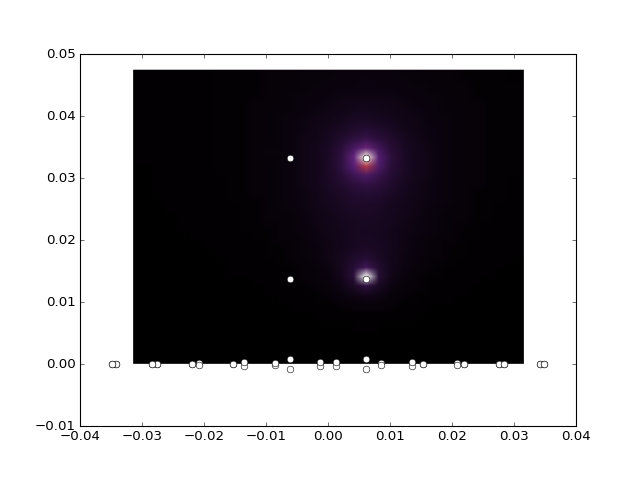

<IPython.core.display.Javascript object>


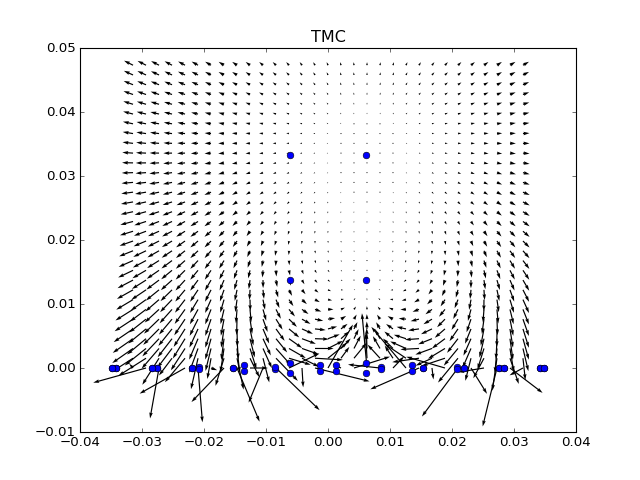

<IPython.core.display.Javascript object>


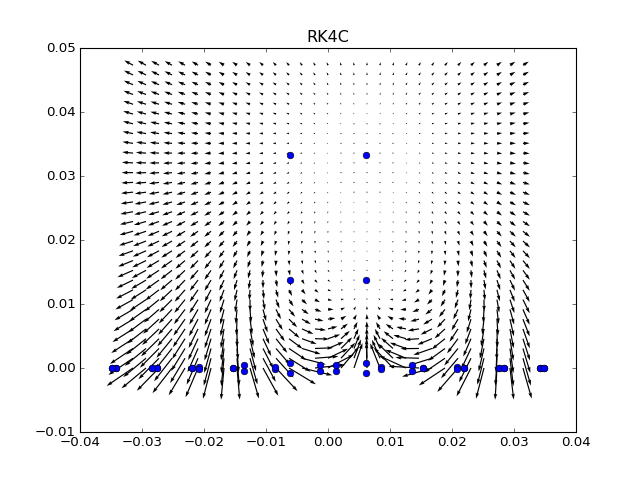

<IPython.core.display.Javascript object>


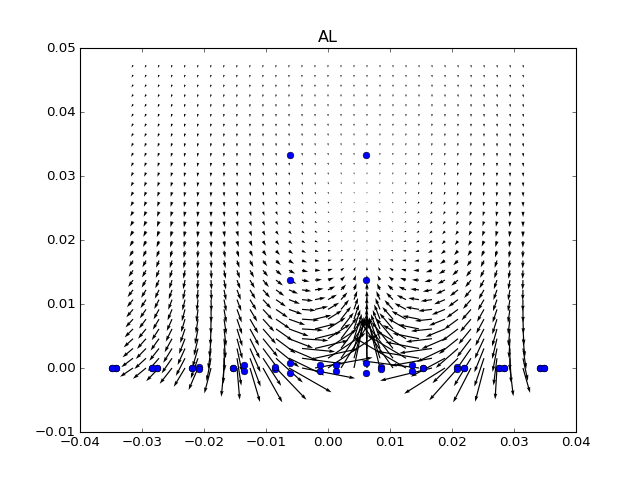

<IPython.core.display.Javascript object>


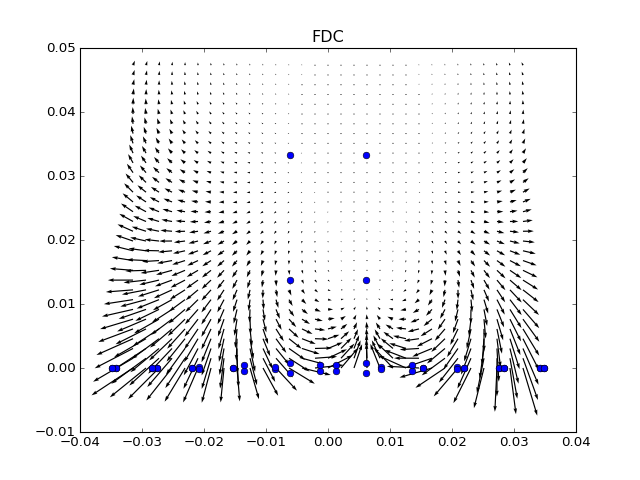

<IPython.core.display.Javascript object>


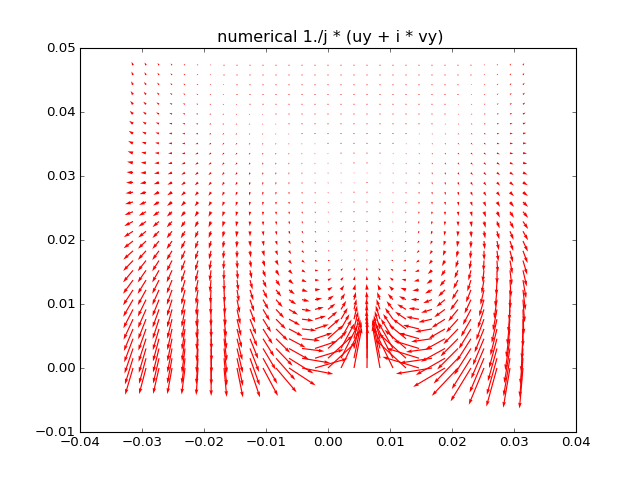

<IPython.core.display.Javascript object>


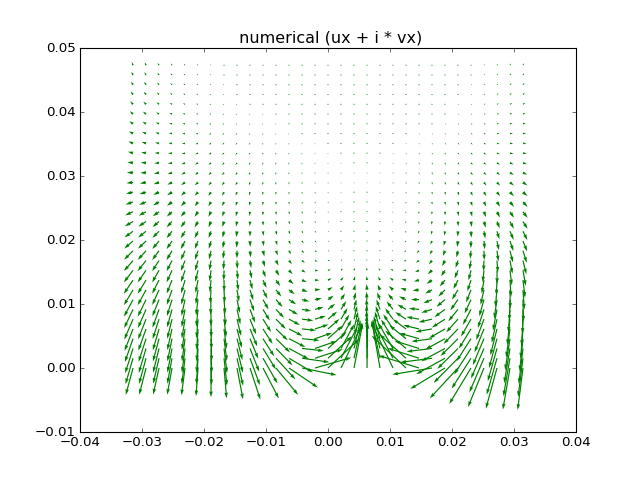

(-0.01, 0.05)

In [1]:
import numpy as np
import matplotlib
from plottingtools import *
%matplotlib nbagg
from dstpy3 import *
from optictools import *
from plottingtools import *

def pmax(t0): 
	return np.abs(b2)/gamma / t0**2

b2 = -23e-27
gamma = 0.0037
t0 = 1e-12

fr=0.05
tvec=np.linspace(-10e-12,10e-12,2**10)
t0 = fr * 20e-12
p = pmax(t0)
feld = 2.2* np.sqrt(p) / np.cosh( tvec/t0) * np.exp( -1.0j * 2 * np.pi * .1e12 * tvec)
dt = tvec[2]-tvec[1]

dob = DSTObj( feld, tvec, b2, gamma)

#calc eigenvalues directly 


evals = dob.calc_evals()

# calc a
ofak = 0.02
opoints = 31
epoints = 32
ov = np.linspace(0, 0.01, opoints)#np.linspace(-dob.ommax, dob.ommax, opoints) * ofak
ov = np.linspace(-dob.ommax, dob.ommax, opoints) * ofak
ev = np.linspace(0, dob.zetamax, epoints)
oo,ee = np.meshgrid(ov,ev)
zetas = oo + 1.0j * ee
aa = np.zeros([epoints, opoints], dtype=complex)
for i in range(epoints):
    a,b = dob.calc_ab(zetas[i,:], method="TMC")
    aa[i,:]=a
   
def imshowhelper(vals):  
    plt.imshow(vals, origin = 'lower', cmap=sunrise(),
              extent=[np.min(ov), np.max(ov), np.min(ev), np.max(ev)])
plt.figure()
imshowhelper(1./np.abs(aa))

plt.plot(np.real(evals), np.imag(evals),'o', mfc='1.0')

plt.xlim(-0.04, 0.04)
plt.ylim(-0.01, 0.05)

#
# calculate adiff using different methods
#
for methds in ['TMC', 'RK4C', 'AL', 'FDC']:
    aa = np.zeros([epoints, opoints], dtype=complex)
    bb = np.zeros([epoints, opoints], dtype=complex)
    aad = np.zeros([epoints, opoints], dtype=complex)
    bbd = np.zeros([epoints, opoints], dtype=complex)
    
    for i in range(epoints):
        a,b,ad,bd = dob.calc_abdiff(zetas[i,:], method=methds)
        aa[i,:]=a
        aad[i,:] = ad
        
    plt.figure()

    plt.quiver( oo,ee, np.real(aad), np.imag(aad))
    plt.plot(np.real(evals), np.imag(evals),'o')
    plt.xlim(-0.04, 0.04)
    plt.ylim(-0.01, 0.05)
    plt.title(methds)
    
dx = ov[2]-ov[1]
dy = ev[2]-ev[1]
greal = np.gradient(np.real(aa))
gimag = np.gradient(np.imag(aa))

d1 = 1./1.0j * (greal[0] *dx + 1.0j * gimag[0]*dy)
d2 =            greal[1] *dy + 1.0j * gimag[1]*dx

plt.figure()
plt.quiver(oo,ee, np.real(d1), np.imag(d1), color='red')
plt.title(" numerical 1./j * (uy + i * vy)")
plt.xlim(-0.04, 0.04)
plt.ylim(-0.01, 0.05)

plt.figure()
plt.quiver(oo,ee, np.real(d2), np.imag(d2), color='green')
plt.title(" numerical (ux + i * vx)")          
plt.xlim(-0.04, 0.04)
plt.ylim(-0.01, 0.05)    


# check rootfinding (unfinished)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


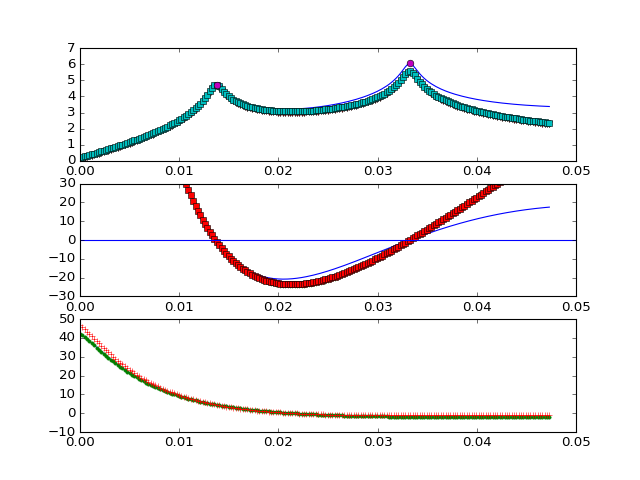

<IPython.core.display.Javascript object>


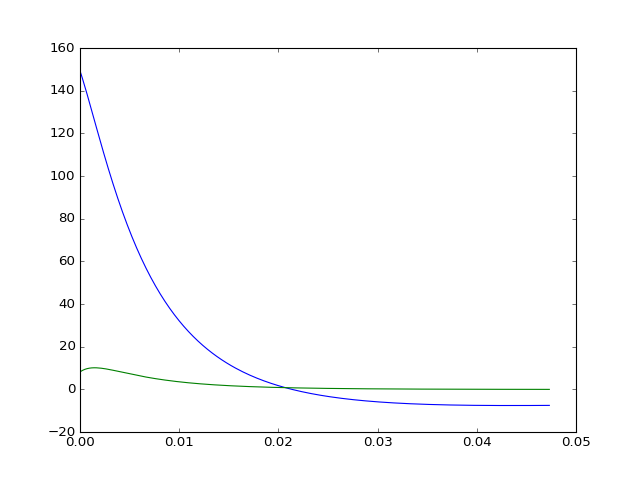

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
%matplotlib nbagg

from matplotlib import pyplot as plt
from dstpy3 import *
from optictools import *
from time import time

from dstpy_rk4augdiff import calc_abdiff_rungekutta_augvanilla

def pmax(t0): 
	return np.abs(b2)/gamma / t0**2

b2 = -23e-27
gamma = 0.0037
t0 = 1e-12



fr=0.05
tvec=np.linspace(-10e-12,10e-12,2**10)
t0 = fr * 20e-12
p = pmax(t0)
feld = 2.2* np.sqrt(p) / np.cosh( tvec/t0) * np.exp( -1.0j * 2 * np.pi * .01e12 * tvec)
dt = tvec[2]-tvec[1]

dob = DSTObj(feld, tvec, b2, gamma)
zetas = np.linspace(0, dob.zetamax,200)

a,b,adiff,bdiff = dob.calc_abdiff(1.0j * zetas, method='FDC')
a2,b2,adiff2,bdiff2 = dob.calc_abdiff(1.0j * zetas, method='TMC')

a3,b3,adiff3,bdiff3 = dob.calc_abdiff(1.0j * zetas, method='AL')

a4, b4, adiff4, bdiff4 = calc_abdiff_rungekutta_augvanilla( dob.dx, dob.L, dob.q, 1.0j * zetas )
pl = pyfindpeaks(10,np.log(1./np.abs(a)),0)

a5, b5, adiff5, bdiff5 = dob.calc_abdiff(1.0j * zetas, method='RK4')
#dob.calc_abdiff(1.0j * zetas, method='RK4C')
#print(pl)

plt.figure()
plt.subplot(311)
plt.plot( zetas, np.log(1./np.abs(a)))
plt.plot( zetas, np.log(1./np.abs(a2)),"+")
plt.plot( zetas, np.log(1./np.abs(a3)),"v")
plt.plot( zetas, np.log(1./np.abs(a4)),"s")
plt.plot( zetas[pl], np.log(1./np.abs(a[pl])),'o')
plt.subplot(312)
plt.plot( zetas, np.imag(adiff))
plt.plot( zetas, np.imag(adiff2),"+")
#plt.plot( zetas, np.imag(adiff3),"v")
plt.plot( zetas, np.imag(adiff4),"s")
plt.axhline(y=0)
plt.ylim([-30,30])
plt.subplot(313)
plt.plot(zetas, np.real(adiff2))
#plt.plot(zetas, np.imag(a/adiff),"o")
#plt.plot(zetas, np.imag(adiff4),"x")
plt.plot(zetas, np.real(adiff4),'.')
#plt.plot(zetas, np.imag(adiff2),"v")
plt.plot(zetas, np.real(adiff),'+')
#plt.plot(zetas, np.imag(a2/adiff2),"+",ms =12)


plt.figure()
plt.plot(zetas, np.imag(adiff3))
plt.plot(zetas, np.real(adiff3))
#plt.figure()
#plt.axhline(y=zetas[pl[0]])
#for i in range(100):
#    print("--- %d ---"%(i+1))
#    a,b,ad,bd = dob.calc_abdiff(zs)
#    print("zk", zs)
#    print("ak", a)
#    print("ad",ad)
#    print("a/ad", a/ad)
#    zs = zs -  a/ad
#    
#    plt.plot(np.real(zs), np.imag(zs),'o')
#    plt.text(np.real(zs), np.imag(zs),str(i))


In [10]:
dob.help()

calc_ab methods available:
(from self.calc_ab_methodsdict.keys())
                           TM : Transfer Matrix (Python)
                           AL : Ablowitz Ladik (Python)
                           AL2 : Ablowitz Ladik Norm (Python)
                           TMC : Transfer Matrix (C)
                           CD : Central Discretization (Python)
                           RK4 : Runge-Kutta 4 (Python)
                           CN : Crank Nicolson (Python)
                           FDC : Forward Discretization (C)
                           RK4C : Runge-Kutta 4 (Python)
                           FD : Forward Discretization (Python)


calc_abdiff methods available:
                           AL : Ablowitz Ladik (Python)
                           TMC : Transfer Matrix (C)
                           RK4 : Runge Kutta 4 (Python)
                           FDC : Forward Discretization (C)
                           RK4C : Runge Kutta 4 (C)
                           FD : Forward

# accuracy and energy

In [3]:
import numpy as np
import matplotlib
%matplotlib nbagg

from matplotlib import pyplot as plt
from dstpy3 import *
from optictools import *
from time import time
import scipy.io as sio


b2 = -23e-27
gamma = 0.042

def ppeak(t0):
    return np.abs(b2) / gamma / t0**2

def ecutrel( t0tw):
    return 1 - np.tanh( 1. / t0tw / 2.)


def pfloop3(do, inizetas, Meth, verbose=False, iterations=10):
	zetas = inizetas
	for i in range(iterations):
		aa,bb = do.calc_ab(1.0j*zetas, method=Meth)
		la = np.log(1./np.abs(aa)) 
		pl = pyfindpeaks(5,la,0)
		zpeak = zetas[pl[0]]
		zetas = np.linspace( (1-0.05**i)* zpeak, (1+0.05**i)*zpeak,len(inizetas))
		if verbose:
			if i==0:
				plt.figure()
				plt.plot(zetas,la)
				plt.plot(zetas[pl],la[pl],'o' )
			print("%d - %e	  la = %e"%(i, zpeak*4.0/do.energyfactor, la[pl[0]]))
	return zpeak

In [4]:
#vary ratio t0 / twindow
aktmethod = 'RK4C'

plt.rcParams['legend.fontsize']=10
t0tw = 10**np.linspace( -3,-.5, 100)
t0twlower = 10**np.linspace( -3,-.5, 20)
TW = 5e-12
tvec = np.linspace(-TW/2., TW/2., 2**12)
dt = tvec[2]-tvec[1]

#check numerical field integration
EcutM = []
for frac in t0tw:
    t0 = frac * TW
    p =  ppeak(t0)
    esoltheo = 2 * t0 * p
    field = np.sqrt( p) / np.cosh(tvec/t0)
    EcutM.append( [ frac,  1 - np.sum(np.abs(field)**2) *dt / esoltheo ])
EcutM=np.array(EcutM)

#check DST calculations
recalc = True
if recalc == True:
    NN = [12, 14, 16, 18]
    ENNdict = {}
    for N in NN:
        EM = []
        for frac in t0twlower:
            tvec  = np.linspace(-TW/2,TW/2, 2**N)
            dt = tvec[2]-tvec[1]
            t0 = frac * TW
            p =  ppeak(t0)
            esoltheo = 2 * t0 * p
            field = np.sqrt( p) / np.cosh(tvec/t0)
            dob = DSTObj( field, tvec, b2, gamma)
            inizetas = np.linspace(1e-10, dob.zetamax, 21)
            zm = pfloop3(dob, inizetas, aktmethod, iterations=10)
            EM.append([frac, 1- zm * 4.0 / dob.energyfactor / esoltheo])
        ENNdict[str(N)] = np.array(EM)
    sio.savemat("testdata/dstt0twn", ENNdict)
else:
    ENNdict = sio.loadmat("testdata/dstt0twn")

    
#
# check Densities
#
densities = 10 ** np.linspace(1,3,15)
twt0s = [10,14,18]
T0 = 1e-12
P = ppeak(T0)
esoltheo = 2 * P * T0


if True:
    EDENSDICT={}
    for frac2 in twt0s:
        EM = []
        for dens in densities:
            TW2 = frac2 * T0
            dt = T0 / dens
            pts = np.ceil( TW2 / dt)
            tvec = np.linspace(-TW2/2.0 , TW2/2.0, pts)
            feld  = np.sqrt(P) / np.cosh(tvec/T0)
            print("Frac2 : %.2f   Fensterbreite: %.2f ps Dichte : %.1f   Punkte : %d  "%( frac2, TW2/1e-12, dens, pts))
            dob = DSTObj(feld, tvec, b2, gamma)
            inizetas = np.linspace(1e-10, dob.zetamax, 21)
            zm = pfloop3(dob, inizetas, aktmethod, iterations=10)
            EM.append( [dens, 1- zm * 4.0 / dob.energyfactor / esoltheo, frac2])
        EDENSDICT[str(frac2)]=np.array(EM)
    sio.savemat("testdata/dstdens", EDENSDICT)
else:
    EDENSDICT=sio.loadmat("testdata/dstdens")

Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 10.0   Punkte : 100  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 13.9   Punkte : 139  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 19.3   Punkte : 194  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 26.8   Punkte : 269  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 37.3   Punkte : 373  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 51.8   Punkte : 518  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 72.0   Punkte : 720  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 100.0   Punkte : 1000  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 138.9   Punkte : 1390  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 193.1   Punkte : 1931  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 268.3   Punkte : 2683  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 372.8   Punkte : 3728  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 517.9   Punkte : 5180  
Frac2 : 10.00   Fensterbreite: 10.00 ps Dichte : 719.7   Punkte :

<IPython.core.display.Javascript object>


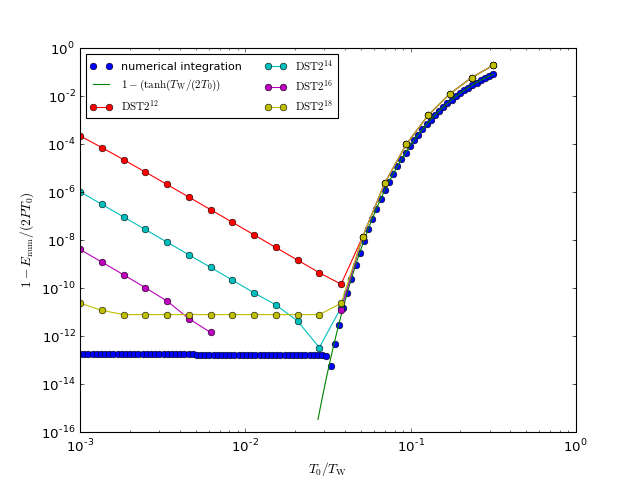

<IPython.core.display.Javascript object>


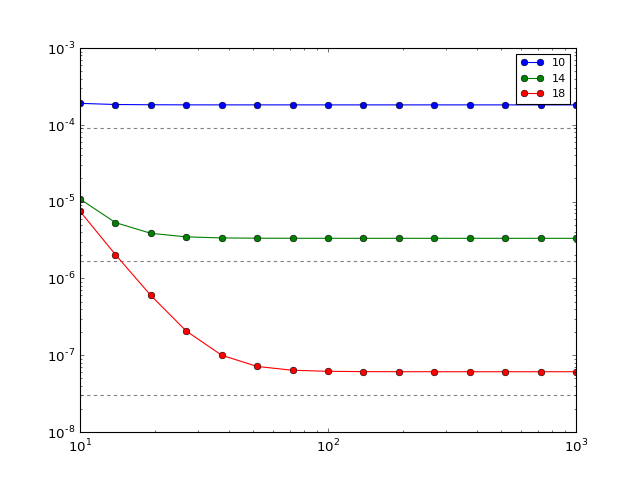

<IPython.core.display.Javascript object>


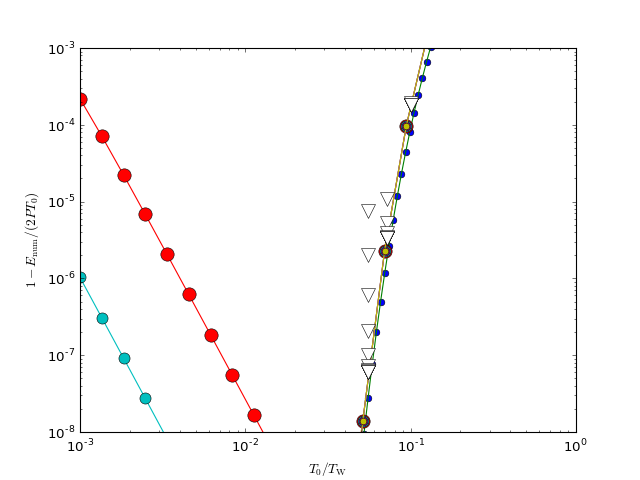

(1e-08, 0.001)

In [5]:
#
# ENERGY DIFFERENCE over T0/TW
#

plt.figure()
plt.loglog( EcutM[:,0], np.abs(  EcutM[:,1]), 'o', label="numerical integration")
plt.plot( EcutM[:,0], ecutrel(EcutM[:,0]), label=r"$1-({\rm tanh}(T_{\rm W}/(2T_0))$")
plt.xlabel(r"$T_0 / T_{\rm W}$")
plt.ylabel(r"$1-E_{\rm num}/ (2PT_0)$")
for N in NN:
    EM = ENNdict[str(N)]
    plt.plot( EM[:,0], EM[:,1], 'o-', label=r"${\rm DST} 2^{%d}$"%N)   
    
plt.legend(loc=0,ncol=2)


#
# ENERGY DIFFERENCE over point density
#
plt.figure()
for f2 in twt0s:
    EM = EDENSDICT[str(f2)]
    #print(EM)
    plt.loglog( EM[:,0], EM[:,1],'o-', label=str(f2))
    plt.axhline(y  = ecutrel(1/f2), dashes=(3,3), c='0.5')
plt.legend(loc=0)
    
    
#
# Put the figs together
#
plt.figure()
plt.loglog( EcutM[:,0], np.abs(  EcutM[:,1]), 'o', label="numerical integration")
plt.plot( EcutM[:,0], ecutrel(EcutM[:,0]), label=r"$1-({\rm tanh}(T_{\rm W}/(2T_0))$")
plt.xlabel(r"$T_0 / T_{\rm W}$")
plt.ylabel(r"$1-E_{\rm num}/ (2PT_0)$")
ms = 12
for N in NN:
    EM = ENNdict[str(N)]
    plt.plot( EM[:,0], EM[:,1], 'o-', label=r"${\rm DST} 2^{%d}$"%N, ms = ms )   
    ms = ms -2
    
    
for f2 in twt0s:
    EM = EDENSDICT[str(f2)]
    #print(EM)
    plt.loglog( 1./EM[:,2], EM[:,1],   'v', ms=12, mfc="1.0", label=str(f2))
    #plt.loglog( 1/EM[:,2], EM[:,1], 'v', ms=12, mfc="1.0")
plt.ylim([1e-8,1e-3])
#plt.legend(loc=0,ncol=2)

# directly calc evals - dummy method

<IPython.core.display.Javascript object>


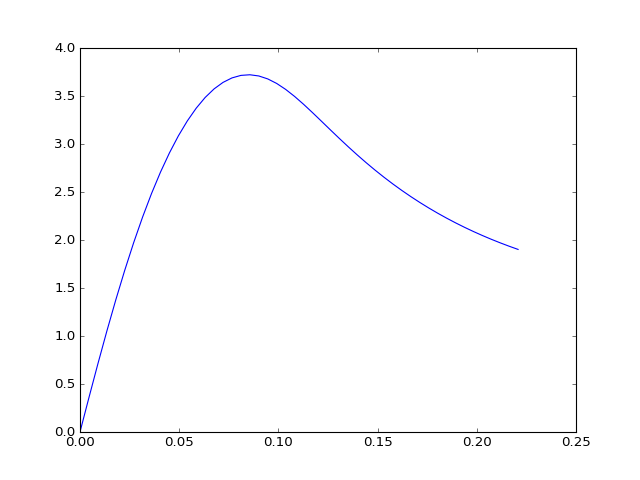

<IPython.core.display.Javascript object>


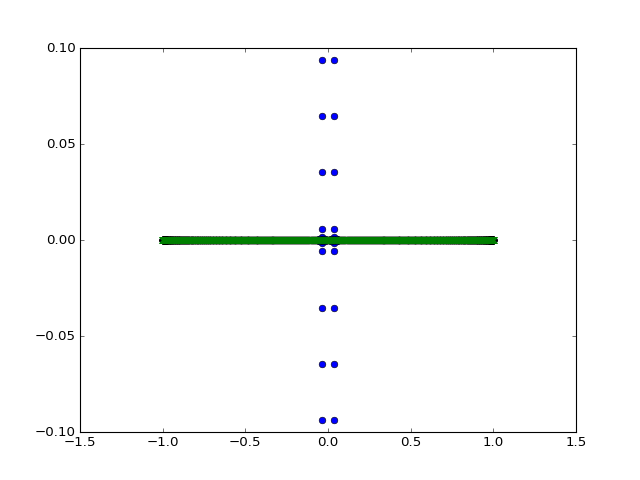

In [35]:
from dstpy3 import *

tvec = np.linspace(-3e-12,3e-12,4*256)
t0 = 0.2e-12
p0 = np.abs(b2/gamma)/t0**2
feld = 3.7 * np.sqrt(p0) / np.cosh(tvec/t0) * np.exp(-2e12 * 1.0j * 2 * np.pi * tvec)
dob = DSTObj(feld, tvec, b2, gamma)
zetas = np.linspace(0, 1.1 * dob.zetamax)
a,b = dob.calc_ab(1.0j * zetas, method='RK4C')

plt.figure()
plt.plot(zetas, np.log(np.abs(1./a)))


def calc_evals(dob ):
		len_q = len(dob.q)
		cdm = np.zeros( [len_q,len_q], dtype=complex)
		for i in range(1, len_q):
			cdm[i,i-1]=-1
			cdm[i-1,i]=1
			cdm[0, len_q-1] = -1
			cdm[len_q-1, 0] = 1
		cdm = cdm / 2. /dob.dx
		MM = np.zeros([2*len_q, 2*len_q], dtype=complex)
		MM[0:len_q, 0:len_q]=cdm
		MM[len_q:2*len_q,len_q:2*len_q] = -cdm
		MM[len_q:2*len_q, 0:len_q] = -np.diag(np.conj(dob.q))
		MM[0:len_q, len_q:2*len_q]=  -np.diag(dob.q)
		MM = 1.0j * MM    
		evals = linalg.eigvalsh(MM)
		return evals
    

evals  = dob.calc_evals()
evals2 = calc_evals(dob)
plt.figure()
plt.plot( np.real(evals), np.imag(evals), 'o')
plt.plot( np.real(evals2), np.imag(evals2), 'x')

-3.42548212018e-12


<IPython.core.display.Javascript object>


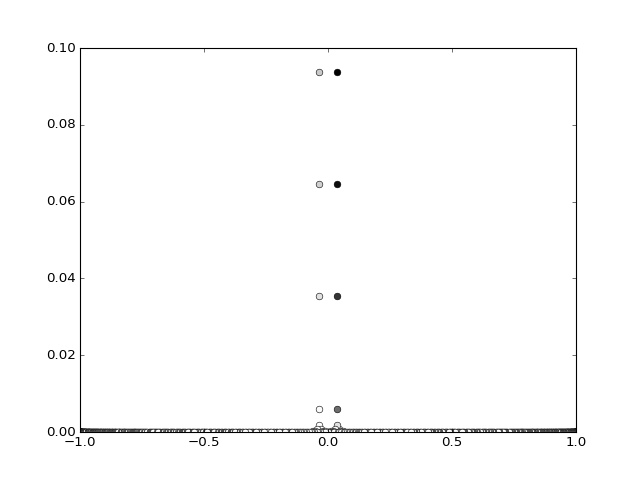

0.037  + i 0.094   |a| = 0.000
-0.037  + i 0.094   |a| = 0.105
-0.037  + i 0.065   |a| = 0.139
0.037  + i 0.065   |a| = 0.000
0.037  + i 0.035   |a| = 0.000
-0.037  + i 0.035   |a| = 0.280
-0.037  + i 0.006   |a| = 0.796
-0.037  + i 0.002   |a| = 0.935
0.037  + i 0.006   |a| = 0.002
0.037  + i 0.002   |a| = 0.295


0.99999999999967637

In [36]:
m = []
evals2 = evals[np.nonzero( np.imag(evals)>0   )]
a,b = dob.calc_ab(evals2)
adas = np.log(1./np.abs(a))
print(np.min(adas))
adasma = np.max(adas)
adasmi = np.min(adas)
plt.figure()
for i in range(len(adas)):
    ev = evals2[i]
    mfcnorm = 1-(adas[i]-adasmi)/(adasma-adasmi)
    
    plt.plot( np.real(ev), np.imag(ev), 'o', mfc = str(mfcnorm))
    
    if np.imag(ev)>1e-3:
        print("%.3f  + i %.3f   |a| = %.3f"%(np.real(ev), np.imag(ev), np.abs( a[i])))
